In [9]:
from PIL import Image
import numpy as np
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from functools import reduce
from random import randint
import math
from numba import jit, float32

In [10]:
# Do not touch

# load the image
image = Image.open('test02.jpg').resize((256, 256))
image.show()

#print image mode
print(image.mode)

# convert image to numpy array (256, 256, 3)
img_tenzor = np.asarray(image)
shape = img_tenzor.shape[:2]
# summarize shape
print(f' img shape {img_tenzor.shape}')

RGB
 img shape (256, 256, 3)


### cut examples 2 for image segments

In [11]:
# #Do not need

# segment_1 = img_tenzor[:50, 30:80]
# segment_2 = img_tenzor[250:, 250:]

# plt.imshow(img_tenzor)
# plt.show()
# plt.imshow(segment_1, interpolation='nearest')
# plt.show()
# plt.imshow(segment_2, interpolation='nearest')
# plt.show()

In [12]:
# #Do not need

# segment_1 = np.concatenate((segment_1), axis=0 )
# segment_1_mean = segment_1.mean(axis=0)
# segment_1_cov = np.cov(segment_1, rowvar=False)

# print(f'segment_1 MEAN  \t{segment_1_mean}\n')
# print(f'segment_1 COV MATRIX\n {segment_1_cov}\n')
# print(f'segment_1 COV MATRIX shape \t {np.shape(segment_1_cov)}')

In [13]:
# #Do not need

# segment_2 = np.concatenate((segment_2), axis=0 )
# segment_2_mean = segment_2.mean(axis=0)
# segment_2_cov = np.cov(segment_2, rowvar=False)

# print(f'segment_2 MEAN  \t{segment_2_mean}\n')
# print(f'segment_2 COV MATRIX\n {segment_2_cov}\n')
# print(f'segment_2 COV MATRIX shape \t {np.shape(segment_2_cov)}')

In [14]:
mu1 = np.array([10,50,20], dtype=np.float64)
mu2 = np.array([200,170,200], dtype=np.float64)
covar = np.array([[10**2,2**2,2**2], [2**2, 10**2, 2**2],[2**2, 2**2, 10**2]], dtype=np.float64)
print(type(covar))

<class 'numpy.ndarray'>


### For each pixel put initial segment type

In [15]:
@jit(nopython=True)        
def norm_pdf_multivariate(x, mu, sigma):
    size = len(x)
    if size == len(mu) and (size, size) == sigma.shape:
        det = np.linalg.det(sigma)
        if det == 0:
            raise NameError("The covariance matrix can't be singular")

        norm_const = 1.0/ (math.pow((2*math.pi),float(size)/2) * math.pow(det,1.0/2) )
        x_mu = x - mu
        inv = np.linalg.inv(sigma)         
        result = math.pow(math.e, -0.5 * ((x_mu).dot(inv).dot(x_mu.T)))
        return norm_const * result
    else:
        raise NameError("The dimensions of the input don't match")
        
        
        
@jit(nopython=True)
def likelyhood(pixel_color_list,  mu1, cov1, mu2, cov2):
    
    pdf_1 = norm_pdf_multivariate(pixel_color_list, mu1, cov1)
    pdf_2 = norm_pdf_multivariate(pixel_color_list,  mu2, cov2)
    
    return pdf_1, pdf_2  #marker color of 1 class and it's probability
    

print(likelyhood(img_tenzor[253][253], mu1, covar, mu2, covar))

(5.167464835253208e-95, 1.462032211403423e-20)


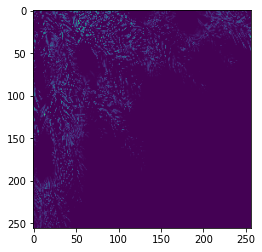

In [16]:
marked_image_data  = np.zeros(shape=(*img_tenzor.shape[:2], 2), dtype=float)

for i, j  in np.ndindex(img_tenzor.shape[:2]):
    marked_image_data[i][j] = likelyhood(img_tenzor[i][j],  mu1, covar, mu2, covar)
    
plt.imshow(marked_image_data[:, :,0])
plt.show()

### find neighbors and sampling

In [18]:
@jit(nopython=True)
def expectation(img_tenzor, p_k1, p_k2, mu1, mu2, cov1, cov2, shape):
    
    alpha_matrix  = np.zeros(shape=(*shape, 2), dtype=float32)
    pk_matrix = np.zeros(shape=(*shape, 2), dtype=float32)
    alpha_1_sum = 0
    alpha_2_sum = 0    
    for i in range(shape[0]):
        for j in range(shape[1]):
            like_1, like_2 = likelyhood(img_tenzor[i][j], mu1, cov1, mu2, cov2)
            numerator1, numerator2 = (p_k1*like_1), (p_k2*like_2)
            alpha_1, alpha_2 = numerator1/(numerator1+numerator2), numerator2/(numerator1+numerator2)
            alpha_matrix[i][j] = alpha_1, alpha_2
            alpha_1_sum += alpha_1
            alpha_2_sum += alpha_2
            p_k1 = alpha_1_sum/(shape[0]*shape[1])
            p_k2 = alpha_2_sum/(shape[0]*shape[1])
    print(p_k1, p_k2)
#     print(alpha_matrix)    
    return alpha_matrix, alpha_1_sum, alpha_2_sum

In [19]:
%%time
p_k1 = 1/2.
p_k2 = 1/2.
for i in range(10):
    expectation(img_tenzor, p_k1, p_k2, mu1, mu2, covar, covar, shape)

0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
0.6855240822463926 0.3144759177536063
CPU times: user 6.16 s, sys: 64.6 ms, total: 6.22 s
Wall time: 6.64 s
